In [ ]:
import re

In [ ]:
modelled_freq='30min'

In [ ]:
freq_time = (re.findall(r'(\d+)(\w+)', modelled_freq)[0][0])

In [ ]:
int(freq_time)

In [ ]:
re?

In [1]:
%pwd

'/home/jovyan/dea_intertidal/dea-intertidal/intertidal'

In [2]:
cd ..

/home/jovyan/dea_intertidal/dea-intertidal


In [3]:
pip install -r requirements.in --quiet

Note: you may need to restart the kernel to use updated packages.


In [58]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import xarray as xr
import re
import datetime
import pytz
import sunriset

from math import ceil
from datetime import timedelta
from shapely.geometry import Point
from numpy import interp
from scipy.signal import argrelmax, argrelmin

from intertidal.utils import (
    round_date_strings,
    intertidal_hillshade,
)
from intertidal.tide_modelling import pixel_tides_ensemble

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
%store -r ds

In [6]:
dem = ds.elevation

In [11]:
tide_model = "ensemble"  # Tide model to use in analysis
tide_model_dir = "/gdata1/data/tide_models_clipped"
start_date = "2020"  # Start date for analysis
end_date = "2022"  # End date for analysis
modelled_freq = "3h"  # Frequency to run tidal model e.g '30min' or '1h'

time_range = pd.date_range(
    start=round_date_strings(start_date, round_type="start"),
    end=round_date_strings(end_date, round_type="end"),
    freq=modelled_freq,
)

calculate_quantiles = np.linspace(0, 1, 101) #nb formerly 'pc_range'

ModelledTides, _ = pixel_tides_ensemble(
    dem,
    # calculate_quantiles=calculate_quantiles,
    times=time_range,
    directory=tide_model_dir,
    ancillary_points="data/raw/tide_correlations_2017-2019.geojson",
    top_n=3,
    reduce_method='mean',
    resolution=3000,
)

stacked_everything = ModelledTides.mean(dim=["x","y"])

# Extract the modelling freq units
# Split the number and text characters in modelled_freq
freq_time = int(re.findall(r'(\d+)(\w+)', modelled_freq)[0][0])
freq_unit = str(re.findall(r'(\d+)(\w+)', modelled_freq)[0][-1])

# Extract the number of modelled timesteps per 14 days (half lunar cycle) for neap/spring calcs
mod_timesteps = pd.Timedelta((29.5/2),"d")/pd.Timedelta(freq_time, freq_unit)

## Identify kwargs for peak detection algorithm
order=(int(mod_timesteps/2))

tide_cq_dict={}
exposure={}
timeranges={}

In [95]:
filters = ['Daylight', 'Night']

for x in filters:
    if x in ['Daylight','Night']: 
        print (f'Calculating {x}')

        # Identify the central coordinate directly from the dem GeoBox
        tidepost_lon_4326, tidepost_lat_4326 = dem.odc.geobox.extent.centroid.to_crs("EPSG:4326").coords[0]

        ## Coordinate point to locate the sunriset calculation
        point_4326 = Point(tidepost_lon_4326, tidepost_lat_4326)

        ## Calculate the local sunrise and sunset times
        # Place start and end dates in correct format
        start = time_range[0]
        end = time_range[-1]
        startdate = datetime.date(pd.to_datetime(start).year, 
                                  pd.to_datetime(start).month, 
                                  pd.to_datetime(start).day)

        # Make 'all_timerange' time-zone aware
        localtides = time_range.tz_localize(tz=pytz.UTC)#.tz_convert(timezone)

        # Replace the UTC datetimes from all_timerange with local times
        modelledtides = pd.DataFrame(index = localtides)

        # Return the difference in years for the time-period. 
        # Round up to ensure all modelledtide datetimes are captured in the solar model
        diff = pd.to_datetime(end) - pd.to_datetime(start)
        diff = int(ceil(diff.days/365))

        local_tz=0
        
        ## Model sunrise and sunset
        sun_df = sunriset.to_pandas(startdate, tidepost_lat_4326, tidepost_lon_4326, local_tz, diff)

        ## Set the index as a datetimeindex to match the modelledtide df
        sun_df = sun_df.set_index(pd.DatetimeIndex(sun_df.index))

        ## Append the date to each Sunrise and Sunset time
        sun_df['Sunrise dt'] = sun_df.index + sun_df['Sunrise']
        sun_df['Sunset dt'] = sun_df.index + (sun_df['Sunset'])

        ## Create new dataframes where daytime and nightime datetimes are recorded, then merged 
        ## on a new `Sunlight` column
        daytime=pd.DataFrame(data = 'Sunrise', index=sun_df['Sunrise dt'], columns=['Sunlight'])
        nighttime=pd.DataFrame(data = 'Sunset', index=sun_df['Sunset dt'], columns=['Sunlight'])
        DayNight = pd.concat([daytime, nighttime], join='outer')
        DayNight.sort_index(inplace=True)
        DayNight.index.rename('Datetime', inplace=True)

        ## Create an xarray object from the merged day/night dataframe
        day_night = xr.Dataset.from_dataframe(DayNight)

        ## Remove local timezone timestamp column in modelledtides dataframe. Xarray doesn't handle 
        ## timezone aware datetimeindexes 'from_dataframe' very well.
        modelledtides.index = modelledtides.index.tz_localize(tz=None)

        ## Create an xr Dataset from the modelledtides pd.dataframe
        mt = modelledtides.to_xarray()

        ## Filter the modelledtides (mt) by the daytime, nighttime datetimes from the sunriset module
        ## Modelled tides are designated as either day or night by propogation of the last valid index 
        ## value forward
        Solar=day_night.sel(Datetime=mt.index, method='ffill')

        ## Assign the day and night tideheight datasets
        SolarDayTides = mt.where(Solar.Sunlight=='Sunrise', drop=True)
        SolarNightTides = mt.where(Solar.Sunlight=='Sunset', drop=True)

        ## Extract DatetimeIndexes to use in exposure calculations
        all_timerange_day = pd.DatetimeIndex(SolarDayTides.index)
        all_timerange_night = pd.DatetimeIndex(SolarNightTides.index)

        if x == 'Daylight':
            timeranges['Daylight'] = all_timerange_day
        if x == 'Night':
            timeranges['Night'] = all_timerange_night

Calculating Daylight
Calculating Night


In [127]:
Solar.Sunlight.where(Solar.Sunlight == 'Sunrise',False)#.plot()

<xarray.DataArray 'Sunlight' (index: 8761)>
array(['Sunrise', 'Sunrise', 'Sunrise', ..., False, 'Sunrise', 'Sunrise'],
      dtype=object)
Coordinates:
    Datetime  (index) datetime64[ns] 2019-12-31T19:36:34.447635 ... 2022-12-3...
  * index     (index) datetime64[ns] 2020-01-01 ... 2022-12-31

In [90]:
timeranges['Daylight']

DatetimeIndex(['2020-01-01 00:00:00', '2020-01-01 03:00:00',
               '2020-01-01 06:00:00', '2020-01-01 09:00:00',
               '2020-01-01 21:00:00', '2020-01-02 00:00:00',
               '2020-01-02 03:00:00', '2020-01-02 06:00:00',
               '2020-01-02 09:00:00', '2020-01-02 21:00:00',
               ...
               '2022-12-29 03:00:00', '2022-12-29 06:00:00',
               '2022-12-29 09:00:00', '2022-12-29 21:00:00',
               '2022-12-30 00:00:00', '2022-12-30 03:00:00',
               '2022-12-30 06:00:00', '2022-12-30 09:00:00',
               '2022-12-30 21:00:00', '2022-12-31 00:00:00'],
              dtype='datetime64[ns]', length=4380, freq=None)

In [92]:
timeranges['Daylight'].tz_localize(pytz.utc).tz_convert('Australia/Adelaide')

DatetimeIndex(['2020-01-01 10:30:00+10:30', '2020-01-01 13:30:00+10:30',
               '2020-01-01 16:30:00+10:30', '2020-01-01 19:30:00+10:30',
               '2020-01-02 07:30:00+10:30', '2020-01-02 10:30:00+10:30',
               '2020-01-02 13:30:00+10:30', '2020-01-02 16:30:00+10:30',
               '2020-01-02 19:30:00+10:30', '2020-01-03 07:30:00+10:30',
               ...
               '2022-12-29 13:30:00+10:30', '2022-12-29 16:30:00+10:30',
               '2022-12-29 19:30:00+10:30', '2022-12-30 07:30:00+10:30',
               '2022-12-30 10:30:00+10:30', '2022-12-30 13:30:00+10:30',
               '2022-12-30 16:30:00+10:30', '2022-12-30 19:30:00+10:30',
               '2022-12-31 07:30:00+10:30', '2022-12-31 10:30:00+10:30'],
              dtype='datetime64[ns, Australia/Adelaide]', length=4380, freq=None)

In [96]:
timeranges['Night'].tz_localize(pytz.utc).tz_convert('Australia/Adelaide')

DatetimeIndex(['2020-01-01 22:30:00+10:30', '2020-01-02 01:30:00+10:30',
               '2020-01-02 04:30:00+10:30', '2020-01-02 22:30:00+10:30',
               '2020-01-03 01:30:00+10:30', '2020-01-03 04:30:00+10:30',
               '2020-01-03 22:30:00+10:30', '2020-01-04 01:30:00+10:30',
               '2020-01-04 04:30:00+10:30', '2020-01-04 22:30:00+10:30',
               ...
               '2022-12-28 04:30:00+10:30', '2022-12-28 22:30:00+10:30',
               '2022-12-29 01:30:00+10:30', '2022-12-29 04:30:00+10:30',
               '2022-12-29 22:30:00+10:30', '2022-12-30 01:30:00+10:30',
               '2022-12-30 04:30:00+10:30', '2022-12-30 22:30:00+10:30',
               '2022-12-31 01:30:00+10:30', '2022-12-31 04:30:00+10:30'],
              dtype='datetime64[ns, Australia/Adelaide]', length=4381, freq=None)

In [98]:
import matplotlib.pyplot as plt

In [108]:
nt = np.full((len(timeranges['Night']),1),1)
day = np.full((len(timeranges['Daylight']),1),2)

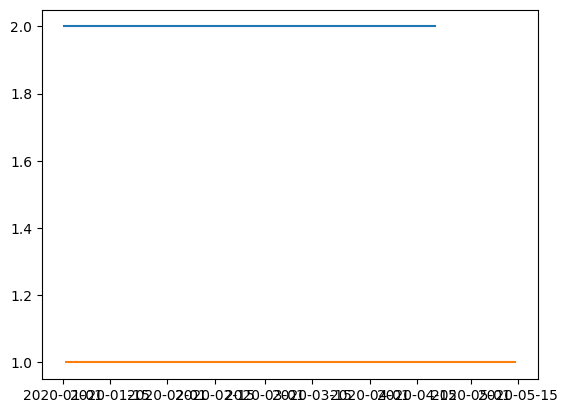

In [110]:
plt.plot(timeranges['Daylight'].tz_localize(pytz.utc).tz_convert('Australia/Adelaide')[0:500],day[0:500])
plt.plot(timeranges['Night'].tz_localize(pytz.utc).tz_convert('Australia/Adelaide')[0:500],nt[0:500])

In [79]:
dt.date().tz_convert(tzinfo=pytz.timezone('Australia/Canberra'))

AttributeError: 'datetime.date' object has no attribute 'tz_convert'

In [ ]:
filters =['Neap_high']

# if x == 'Spring_high' or x == 'Spring_low':
for x in filters:
    if x in ['Spring_high', 'Spring_low', 'Neap_high', 'Neap_low']:

        print (f'Calculating {x}')

        #1D tide modelling workflow

        ## apply the peak detection routine
        if x in ['Spring_high', 'Neap_high']:
            stacked_everything_peaks = argrelmax(stacked_everything.values, order=order)[0]
        if x in ['Spring_low', 'Neap_low']:
            stacked_everything_peaks = argrelmin(stacked_everything.values, order=order)[0]
        if x == 'Neap_high':       
            ## apply the peak detection routine to calculate all the high tide maxima
            Max_testarray = argrelmax(stacked_everything.values)[0]
            
            Max_testarray = stacked_everything.isel(time=Max_testarray)
            ## extract all hightide peaks
            Max_testarray = ModelledTides.to_dataset().sel(time=Max_testarray.time)
            ## repeat the peak detection to identify neap high tides (minima in the high tide maxima)
            stacked_everything2 = Max_testarray.mean(dim=["x","y"])
            ## extract neap high tides based on 14 day half lunar cycle - determined as the fraction of all high tide points
            ## relative to the number of spring high tide values
            order_nh = int(ceil((len(Max_testarray.time)/(len(stacked_everything_peaks))/2)))
            ## apply the peak detection routine to calculate all the neap high tide minima within the high tide peaks
            neap_peaks = argrelmin(stacked_everything2.tide_m.values, order=order_nh)[0] 

        if x == 'Neap_low':       
            ## apply the peak detection routine to calculate all the high tide maxima
            Max_testarray = argrelmin(stacked_everything.values)[0]
            
            Max_testarray = stacked_everything.isel(time=Max_testarray)
            ## extract all hightide peaks
            Max_testarray = ModelledTides.to_dataset().sel(time=Max_testarray.time)
            ## repeat the peak detection to identify neap high tides (maxima in the low tide minima)
            stacked_everything2 = Max_testarray.mean(dim=["x","y"])
            ## extract neap high tides based on 14 day half lunar cycle - determined as the fraction of all high tide points
            ## relative to the number of spring high tide values
            order_nh = int(ceil((len(Max_testarray.time)/(len(stacked_everything_peaks))/2)))
            ## apply the peak detection routine to calculate all the neap high tide minima within the high tide peaks
            neap_peaks = argrelmax(stacked_everything2.tide_m.values, order=order_nh)[0]

        if x in ['Neap_high', 'Neap_low']: 
            ## extract neap high tides
            neappeaks = Max_testarray.isel(time=neap_peaks)

            timeranges[str(x)]=pd.to_datetime(neappeaks.time)

            # Extract the peak height dates
            tide_cq = neappeaks.quantile(q=calculate_quantiles,dim='time')


        if x in ['Spring_high', 'Spring_low']:  
            # select for indices associated with peaks
            springpeaks = stacked_everything.isel(time=stacked_everything_peaks)

            # Select dates associated with detected peaks
            springpeaks = ModelledTides.to_dataset().sel(time=springpeaks.time)

            # Save datetimes for calculation of combined filter exposure
            timeranges[str(x)]=pd.to_datetime(springpeaks.time)

            # Extract the peak height dates
            tide_cq = springpeaks.quantile(q=calculate_quantiles,dim='time')

        # Add tide_cq to output dict
        tide_cq_dict[str(x)]=tide_cq.tide_m

        # Calculate the tide-height difference between the elevation value and
        # each percentile value per pixel
        diff = abs(tide_cq.tide_m - dem)

        # Take the percentile of the smallest tide-height difference as the
        # exposure % per pixel
        idxmin = diff.idxmin(dim="quantile")

        # Convert to percentage
        exposure[str(x)] = idxmin * 100 
    


In [ ]:
tide_cq_dict

In [ ]:
tide_cq

In [ ]:
# exposure['Neap_high'].plot()
int(ceil((len(Max_testarray.time)/(len(stacked_everything_peaks))/2)))
# len(stacked_everything_peaks)
# len(Max_testarray.time)
# stacked_everything.isel(time=Max_testarray)
# order

testc = argrelmax(stacked_everything2.tide_m.values, order=order_nh)[0] #order_nh

stacked_everything2.tide_m[0:340].plot(marker='o')
Max_testarray.tide_m.isel(time=testc).mean(dim=["x","y"])[0:16].plot(marker='o',color='red')


In [ ]:
testb = stacked_everything.isel(time=argrelmin(stacked_everything.values)[0])

In [ ]:
stacked_everything[0:600].plot()
stacked_everything.isel(time=stacked_everything_peaks)[0:6].plot()
stacked_everything2.tide_m[0:100].plot(marker='o')
# testb[0:100].plot(marker='o')
# stacked_everything2.tide_m.sel(time=neaphighs_all).plot()
Max_testarray.tide_m.isel(time=neap_peaks).mean(dim=["x","y"])[0:6].plot(marker='o',color='red')
# neappeaks.plot()
# springpeaks.plot()#.isel(time=stacked_everything_peaks2).plot()
# test.plot()

In [ ]:
stacked_everything[0:600].plot()
stacked_everything.isel(time=stacked_everything_peaks)[0:6].plot()
stacked_everything2.tide_m[0:100].plot(marker='o')
# testb[0:100].plot(marker='o')
# stacked_everything2.tide_m.sel(time=neaphighs_all).plot()
Max_testarray.tide_m.isel(time=neap_peaks).mean(dim=["x","y"])[0:6].plot(marker='o',color='red')
# neappeaks.plot()
# springpeaks.plot()#.isel(time=stacked_everything_peaks2).plot()
# test.plot()

In [ ]:
stacked_everything[0:1200].plot()
stacked_everything.isel(time=stacked_everything_peaks)[0:10].plot()
# stacked_everything2.tide_m.sel(time=neaphighs_all).plot()
Max_testarray.tide_m.isel(time=neaphighs_all).mean(dim=["x","y"])[0:10].plot()
# neappeaks.plot()
# springpeaks.plot()#.isel(time=stacked_everything_peaks2).plot()
# test.plot()

In [ ]:
print(len(Max_testarray.time))
len(stacked_everything2.tide_m)

In [ ]:
exposure#['Spring_high'].plot()

In [ ]:
list = ['a','b','c','d']

for x in list:
    # if x == 'a' or x== 'b':
    if x in ['a','b','f','x']:
    # if x == 'a'|'b':
        print (x)
    else:
        print('not in list')

In [ ]:
if x == 'Neap_high':
    print ('Calculating Neap_high')
    ## Calculate the number of spring high tides to support calculation of neap highs
    ## apply the peak detection routine
    stacked_everything_high = stacked_everything.apply(lambda x: xr.DataArray(argrelmax(x.values, order=order)[0]))
    ## Unstack
    springhighs_all = stacked_everything_high.unstack('z')

    ## apply the peak detection routine to calculate all the high tide maxima
    Max_testarray = stacked_everything.apply(lambda x: xr.DataArray(argrelmax(x.values)[0]))
    ## extract the corresponding dates from the peaks
    Max_testarray = (Max_testarray.unstack('z'))
    Max_testarray = (Max_testarray.reindex(y=Max_testarray.y[::-1])
                     .rename({'dim_0':'time'})
                     .to_dataset(name = 'time')
                     [['time','y','x']]
                    )
    ## extract all hightide peaks
    # Max_testarray = ModelledTides[0].to_dataset().isel(time=Max_testarray.time)
    Max_testarray = ModelledTides.to_dataset().isel(time=Max_testarray.time)## removed reference to ModelledTides[0]. Possibly an artefact of new pixel_tides_ensemble func. If using pixel_tides, may need to revert to ModelledTides[0].

    ## repeat the peak detection to identify neap high tides (minima in the high tide maxima)
    stacked_everything2 = Max_testarray.tide_m.stack(z=['y','x']).groupby('z')
    ## extract neap high tides based on 14 day half lunar cycle - determined as the fraction of all high tide points
    ## relative to the number of spring high tide values
    order_nh = int(ceil((len(Max_testarray.time)/(len(springhighs_all))/2)))
    ## apply the peak detection routine to calculate all the neap high tide minima within the high tide peaks
    neaphighs_all = stacked_everything2.apply(lambda x: xr.DataArray(argrelmin(x.values, order=order_nh)[0]))
    ## unstack and format as above                                    
    neaphighs_all = neaphighs_all.unstack('z')
    neaphighs_all = (
                    neaphighs_all
                     .reindex(y=neaphighs_all.y[::-1])
                     .rename({'dim_0':'time'})
                     .to_dataset(name = 'time')
                     [['time','y','x']]
                    )
    ## extract neap high tides
    neaphighs_all = Max_testarray.isel(time=neaphighs_all.time)

    ## Save datetimes for calculation of combined filter exposure
    timeranges['Neap_high'] = pd.to_datetime(neaphighs_all.isel(x=1,y=1).time)

    tide_cq = neaphighs_all.tide_m.quantile(q=calculate_quantiles,dim='time')

    # Add tide_cq to output dict
    tide_cq_dict[str(x)]=tide_cq

    # Calculate the tide-height difference between the elevation value and
    # each percentile value per pixel
    diff = abs(tide_cq - dem)

    # Take the percentile of the smallest tide-height difference as the
    # exposure % per pixel
    idxmin = diff.idxmin(dim="quantile")

    # Convert to percentage
    exposure['Neap_high'] = idxmin * 100


In [ ]:
stacked_everything_high[0]

In [ ]:
stacked_everything

In [ ]:
stacked_everything.plot()
stacked_everything.isel(time=stacked_everything_high).plot()

In [ ]:
def highestlowtides(z):
    '''
    x is a grouping of x and y pixels from the peaks_array (labelled as 'z')
    '''

    ## apply the peak detection routine to calculate all the high tide maxima
    low_peaks = np.array(argrelmin(z.values)[0])

    ## extract all hightide peaks
    Min_testarray = z.isel(time=low_peaks)

    ## Identify all lower hightide peaks
    highlow_peaks = np.array(argrelmax(Min_testarray.values)[0])

    ## Interpolate the lower hightide curve
    neap_low_linear = interp(
                            ## Create an array to interpolate into
                            np.arange(0,len(z.time)),
                            ## low high peaks as a subset of all high tide peaks
                            low_peaks[highlow_peaks],
                            ## Corresponding tide heights
                            Min_testarray.isel(time=highlow_peaks).squeeze(['z']).values,
                            )

    # # Extract hightides as all tides higher than/equal to the extrapolated lowest high tide line
    lowtide = z.squeeze(['z']).where(z.squeeze(['z']) <= neap_low_linear, drop=True)

    return lowtide 

In [ ]:
## Vectorise the lowtide calculation
highlows_all = stacked_everything.apply(lambda x: xr.DataArray(highestlowtides(x)))
# highlows_all = stacked_everything.map(lambda y: xr.DataArray(highestlowtides(y)))

In [ ]:
import matplotlib.pyplot as plt

In [ ]:

stacked_everything[0:300].plot(marker='.', linestyle='', color='blue', zorder=10)
low_peaks2[0:70].plot(linestyle='', color='orange')
highlow_peaks2[0:30].plot(linestyle='', color='g')
plt.plot(stacked_everything.time[0:300], high_low_linear[0:300])
lowtide[0:100].plot(marker='o', color='black', zorder=1, linestyle='')

In [ ]:
# calculate all the low tide maxima
low_peaks = argrelmin(stacked_everything.values)[0]

# extract all lowtide peaks
low_peaks2 = stacked_everything.isel(time=low_peaks)

# identify all higher lowtide peaks
highlow_peaks = argrelmax(low_peaks2.values)[0]

# extract all higher lowtide peaks
highlow_peaks2 = low_peaks2.isel(time=highlow_peaks)

# interpolate the higher lowtide curve
high_low_linear = interp(np.arange(0,len(stacked_everything)),
                         low_peaks[highlow_peaks],
                         highlow_peaks2.values)
# Extract all tides lower than/equal to the extrapolated higher lowtide line
lowtide = stacked_everything.where(stacked_everything <= high_low_linear, drop=True)

## Save datetimes for calculation of combined filter exposure
timeranges['Lowtide'] = pd.to_datetime(lowtide.time)

tide_cq = lowtide.quantile(q=calculate_quantiles,dim='time').to_dataset()

In [ ]:
tide_cq.to_dataset()

In [ ]:
stacked_everything